Обучить сиамскую сеть для верификации лиц на датасете LFW Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train[:20%]',
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteOK646K/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
len(train_ds)

2647

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

Label: b'Tom_Amstutz'


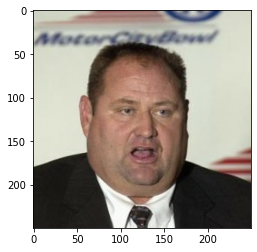

In [6]:
for example in train_ds.take(1):  # Only take a single example
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

In [7]:
for i,j in enumerate(train_ds):
    if i < 3:
        print(i, j)
    else:
        break

0 (<tf.Tensor: shape=(), dtype=string, numpy=b'Tom_Amstutz'>, <tf.Tensor: shape=(250, 250, 3), dtype=uint8, numpy=
array([[[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       ...,

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 24,  22,  23],
        [ 23,  21,  22],
        [ 23,  21,  22]],

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 27,  25,  26],
        [ 25,  23,  24],
        [ 24,  22,  23]],

       [[ 30,  29,  25],
        [ 29,  28,  24

Создание модели CNN

In [8]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

Contrastive Loss

In [9]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

Подготовка пайплайна данных

In [10]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [11]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=10000, seed=5)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [12]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

Визуализация датасета

In [13]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

In [14]:
labels

array([b'Reggie_Miller', b'Yoriko_Kawaguchi', b'Michael_Bolton',
       b'Yang_Hee_Kim'], dtype=object)

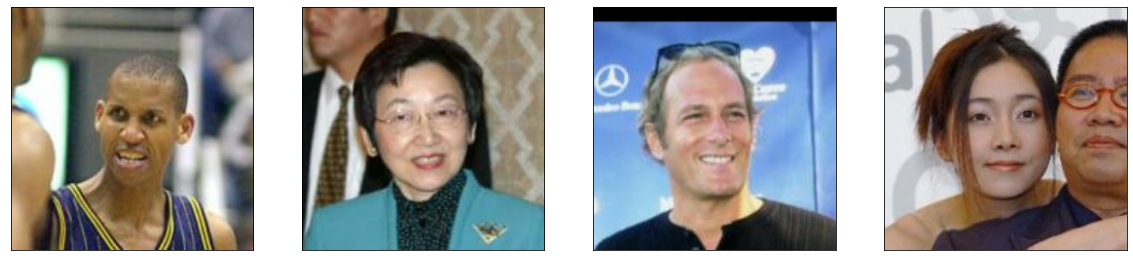

In [15]:
fontdict = {'fontsize': '14', 'color': 'white'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

Подготовка к обучению

In [16]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

Обучение модели

In [35]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 7.877214431762695
[200] Loss: 5.750467300415039
CPU times: user 1min 42s, sys: 3.1 s, total: 1min 45s
Wall time: 2min 5s


Тестирование на новых данных

In [36]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('timati_1.jpg')
img_a2 = load_and_prepare_image('timati_2.jpg')
img_b = load_and_prepare_image('klava_koka.jpg')
img_c = load_and_prepare_image('Elizaveta.jpg')

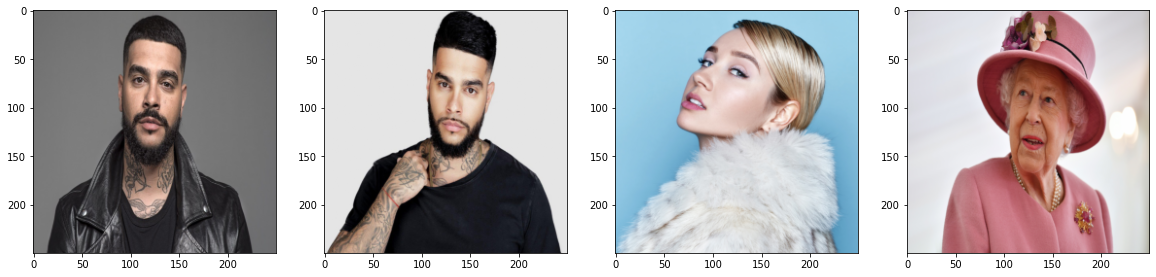

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_c)
plt.show()

Получение эмбеддингов для новых данных

In [38]:
new_embs = model(np.stack((img_a1, img_a2, img_b, img_c), axis=0))

Вычисление расстояний между эмбеддингами

In [40]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #timati
emb2 = new_embs[1,:] #pushkin
emb3 = new_embs[2,:] #klava_koka
emb4 = new_embs[3,:] #Elizaveta

print('timati <-> timati: ', diff(emb1, emb2))
print('timati <-> klava_koka: ', diff(emb2, emb3))
print('timati <-> Elizaveta: ', diff(emb1, emb4))
print('timati <-> Elizaveta: ', diff(emb2, emb4))

timati <-> timati:  85.91642071022424
timati <-> klava_koka:  86.92502213204348
timati <-> Elizaveta:  106.96653152826589
timati <-> Elizaveta:  89.42483313515324


Эмбеддинги фотографий Тимати и Елизаветы 2 больше расстояние чем у двух фотографий тимати